# Explaining Keras image classifier predictions

If we have a model that takes in an image as input, and outputs a class score, we can use ELI5 to check what is it in the image that made the model decide on a certain class. We do that using a method called 'Grad-CAM'.

We will be using images from ImageNet (for more information see http://image-net.org/), and classifiers from `keras.applications`. 

This has been tested with Python 3.7.3, Keras 2.2.4, and Tensorflow 1.13.1.

## 1. Explaining the model's prediction

To start out, lets load our image classifier and data.

Using TensorFlow backend.


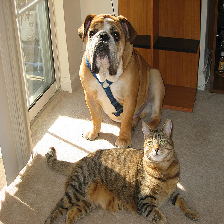

In [1]:
from PIL import Image
from IPython.display import display

import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR) # disable Tensorflow warnings for this tutorial
import warnings
warnings.simplefilter("ignore") # disable Keras warnings for this tutorial
import keras
from keras.applications import mobilenet_v2

import eli5

# let's instantiate our model
model = mobilenet_v2.MobileNetV2(include_top=True, weights='imagenet', classes=1000)

# and load our sample image
image = 'imagenet-samples/cat_dog.jpg'  # TODO: replace this image with something more interesting

dims = model.input_shape[1:3] # 224x224
doc = eli5.keras.image_from_path(image, image_shape=dims)
doc = mobilenet_v2.preprocess_input(doc) # mobilenetv2-specific preprocessing (this operation is in-place)

# looking good?
display(keras.preprocessing.image.array_to_img(doc[0]))

Let's classify our image and see where the network 'looks' when making that classification:

Taking top prediction: 243


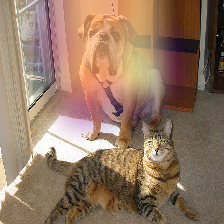

In [2]:
eli5.show_prediction(model, doc)

The class ID (index into the output layer) `243` stands for `bull mastiff` in ImageNet with 1000 classes (https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a ). Indeed we have a dog in the picture. According to Grad-CAM, the area over the dog helped the model decide this. Makes sense!

## 2. Choosing the target class (target prediction)

We can make the model classify other objects and check where the classifier looks to find those objects.

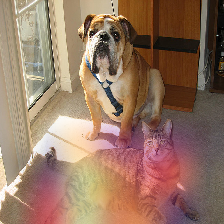

In [3]:
cat_idx = 282 # ImageNet ID for "tiger_cat" class, because we have a cat in the picture
eli5.show_prediction(model, doc, targets=[cat_idx]) # pass the class id

The model looks at the cat now!

We have to pass the class ID as a list to the `targets` parameter.

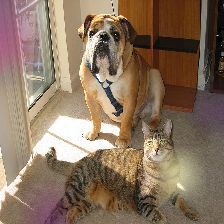

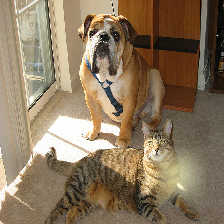

In [4]:
window_idx = 904 # 'window screen'
turtle_idx = 35 # 'mud turtle', some nonsense
display(eli5.show_prediction(model, doc, targets=[window_idx]))
display(eli5.show_prediction(model, doc, targets=[turtle_idx]))

That's quite noisy! Perhaps the model is weak at classifying 'window screens'! The nonsense example could be excused.


Note that we need to wrap `show_prediction()` with `IPython.display.display()` to actually display the image when `show_prediction()` is not the last thing in a cell.

## 3. Choosing a hidden activation layer

Under the hood Grad-CAM takes a hidden layer inside the network and differentiates it with respect to the output scores. We have the ability to choose which hidden layer we do our computations on.

Let's check what layers the network consists of:

In [5]:
# we could use model.summary() here, but the model has over 100 layers. 
# we will only look at the first few and last few layers

head = model.layers[:5]
tail = model.layers[-8:]

def pretty_print_layers(layers):
    for l in layers:
        info = [l.name, type(l).__name__, l.output_shape, l.count_params()]
        pretty_print(info)

def pretty_print(lst):
    s = ',\t'.join(map(str, lst))
    print(s)

pretty_print(['name', 'type', 'output shape', 'param. no'])
print('-'*100)
pretty_print([model.input.name, type(model.input), model.input_shape, 0])
pretty_print_layers(head)
print()
print('...')
print()
pretty_print_layers(tail)

name,	type,	output shape,	param. no
----------------------------------------------------------------------------------------------------
input_1:0,	<class 'tensorflow.python.framework.ops.Tensor'>,	(None, 224, 224, 3),	0
input_1,	InputLayer,	(None, 224, 224, 3),	0
Conv1_pad,	ZeroPadding2D,	(None, 225, 225, 3),	0
Conv1,	Conv2D,	(None, 112, 112, 32),	864
bn_Conv1,	BatchNormalization,	(None, 112, 112, 32),	128
Conv1_relu,	ReLU,	(None, 112, 112, 32),	0

...

block_16_depthwise_relu,	ReLU,	(None, 7, 7, 960),	0
block_16_project,	Conv2D,	(None, 7, 7, 320),	307200
block_16_project_BN,	BatchNormalization,	(None, 7, 7, 320),	1280
Conv_1,	Conv2D,	(None, 7, 7, 1280),	409600
Conv_1_bn,	BatchNormalization,	(None, 7, 7, 1280),	5120
out_relu,	ReLU,	(None, 7, 7, 1280),	0
global_average_pooling2d_1,	GlobalAveragePooling2D,	(None, 1280),	0
Logits,	Dense,	(None, 1000),	1281000


Rough print but okay.
Let's pick a few convolutional layers that are 'far apart' and do Grad-CAM on them:

block_2_expand
Taking top prediction: 243


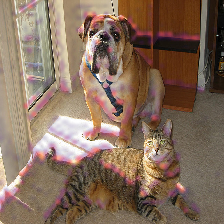

block_9_expand
Taking top prediction: 243


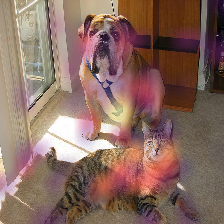

Conv_1
Taking top prediction: 243


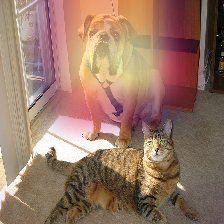

In [6]:
for l in ['block_2_expand', 'block_9_expand', 'Conv_1']:
    print(l)
    display(eli5.show_prediction(model, doc, layer=l)) # we pass the layer as an argument

These results should make intuitive sense for Convolutional Neural Networks. Initial layers detect 'low level' features, ending layers detect 'high level' features!

The `layer` parameter accepts a layer instance, index, name, or None (get layer automatically) as its arguments. This is where Grad-CAM builds its heatmap from.

## 4. Under the hood - `explain_prediction()` and `format_as_image()`

This time we will use the `eli5.explain_prediction()` and `eli5.format_as_image()` functions (that are called one after the other by the convenience function `eli5.show_prediction()`), so we can better understand what is going on.

In [7]:
expl = eli5.explain_prediction(model, doc)

Taking top prediction: 243


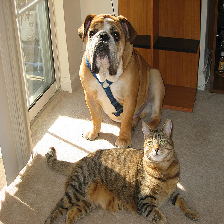

[[0.         0.34700313 0.8183028  0.8033573  0.9006027  0.11643576
  0.01095222]
 [0.01533252 0.3834123  0.80703676 0.8511705  0.953165   0.28513837
  0.        ]
 [0.0070803  0.20260036 0.7718989  0.7773378  1.         0.3023881
  0.        ]
 [0.         0.04289365 0.44958755 0.30086696 0.2511559  0.06772005
  0.        ]
 [0.01483668 0.         0.         0.         0.         0.00579806
  0.01929005]
 [0.         0.         0.         0.         0.         0.
  0.05308533]
 [0.         0.         0.         0.         0.         0.01124774
  0.06864652]]


In [8]:
display(expl.image) # the .image attribute is a PIL image
print(expl.heatmap) # the .heatmap attribute is a numpy array

Visualizing the heatmap:

In [9]:
heatmap_im = eli5.formatters.image.heatmap_to_grayscale(expl.heatmap)
display(heatmap_im)

That's only 7x7! This is the spatial dimensions of the activation/feature maps in the last layers of the network. What Grad-CAM produces is only a rough approximation.

Let's resize the heatmap (we have to pass the heatmap and the image with the required dimensions as PIL Image objects, and the interpolation method):

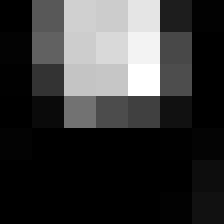

In [10]:
heatmap_im = eli5.formatters.image.resize_over(heatmap_im, expl.image, Image.BOX)
display(heatmap_im)

Now it's clear what is being highlighted. We just need to apply some colors and overlay the heatmap over the original image, exactly what `eli5.format_as_image()` does!

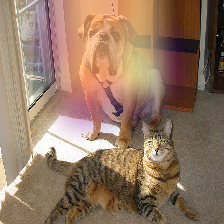

In [11]:
I = eli5.format_as_image(expl)
display(I)

## 5. Extra arguments to `format_as_image()`

`format_as_image()` has a couple of parameters too:

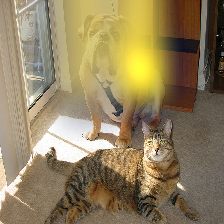

In [12]:
import matplotlib.cm

I = eli5.format_as_image(expl, alpha_limit=1., colormap=matplotlib.cm.cividis)
display(I)

The `alpha_limit` argument controls the maximum opacity that the heatmap pixels should have. It is between 0.0 and 1.0. Low values are useful for seeing the original image.

The `colormap` argument is a function (callable) that does the colorisation of the heatmap. See `matplotlib.cm` for some options. Pick your favourite color!

Another optional argument is `interpolation`. The default is `PIL.Image.LANCZOS` (shown here). You have already seen `PIL.Image.BOX`.

## 6. Removing softmax

The original Grad-CAM paper (https://arxiv.org/pdf/1610.02391.pdf) suggests that we should use the output of the layer before softmax when doing Grad-CAM. Currently ELI5 simply takes the model as-is. Let's try and swap the softmax (logits) layer of our current model with a linear (no activation) layer, and check the explanation:

Taking top prediction: 243


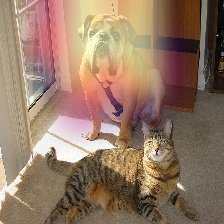

In [13]:
l = model.get_layer(index=-1) # get the last, output layer
l.activation = keras.activations.linear # swap activation

# save and load back the model as a trick to reload the graph
model.save('tmp_model_save_rmsoftmax') # note that this creates a file of the model
model = keras.models.load_model('tmp_model_save_rmsoftmax')

eli5.show_prediction(model, doc)

We see some slight differences. The activations are brighter. Do consider swapping out softmax if explanations for your model seem off.

## 7. Comparing explanations of different models

According to the paper at https://arxiv.org/abs/1711.06104, if an explanation method such as Grad-CAM is any good, then explaining different models should yield different results. Let's verify that by loading another model and explaining a classification of the same image:

mobilenetv2_1.00_224
Taking top prediction: 243


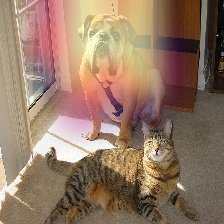

NASNet
Taking top prediction: 243


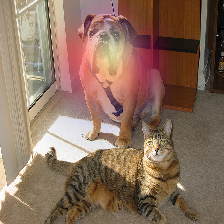

In [14]:
from keras.applications import nasnet

model2 = nasnet.NASNetMobile(include_top=True, weights='imagenet', classes=1000)

# we reload the image to apply nasnet-specific preprocessing
doc2 = eli5.keras.image_from_path(image, image_shape=dims)
doc2 = nasnet.preprocess_input(doc2)

print(model.name)
display(eli5.show_prediction(model, doc))
print(model2.name)
display(eli5.show_prediction(model2, doc2))

Wow `show_prediction()` is so robust!